# Импорт библиотек

In [54]:
# based on https://www.kaggle.com/konstanter/fasterrcnn-pytorch-maskdetection

import numpy as np 
import pandas as pd 
#import torchvision
#from torchvision import transforms, datasets, models
#from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch
#from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
#import matplotlib.patches as patches
#import albumentations as A
#from albumentations.pytorch.transforms import ToTensorV2
import cv2
import os
#import glob
import xml.etree.ElementTree as et
import torchmetrics
#import statistics
import seaborn as sns
from functions import *
import shutil
from PIL import Image as pilim, ImageDraw
from distutils.dir_util import copy_tree
from IPython.display import Image
from torchvision.utils import save_image

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp gdrive/MyDrive/functions.py .

from functions import *

In [ ]:
if not os.path.exists("data"):
    !unzip -q gdrive/MyDrive/data.zip -d ../content/

# Загрузка данных в DataLoader

In [8]:
os.chdir('/home/ss/Documents/ds/git/MedMask_detection')

# путь к файлам
#images_dir = './data/images/'
#annotations_dir = './data/annotations/'
images_dir = '/home/ss/Documents/ds/git/MedMask_detection/data/images/'
annotations_dir = '/home/ss/Documents/ds/git/MedMask_detection/data/annotations/'
test_imgs = '/home/ss/Documents/ds/git/MedMask_detection/data/test_imgs/'
test_anns = '/home/ss/Documents/ds/git/MedMask_detection/data/test_anns/'

class FaceMaskDataset(torch.utils.data.Dataset):

    def __init__(self, images_dir, annotation_dir,width, height, transforms=None):
        self.transforms = transforms
        self.images_dir = images_dir
        self.annotation_dir = annotation_dir
        self.height = height
        self.width = width
        
        # сортировка изображений
        self.imgs = [image for image in sorted(os.listdir(images_dir))]
        self.annotate = [image for image in sorted(os.listdir(annotation_dir))]
        
        # на 0й позиции находится фон
        self.classes = [_, 'without_mask','with_mask','mask_weared_incorrect']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.images_dir, img_name)

        # изменение цвета и размера изображения    
        img = cv2.imread(image_path) #HWC
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # нормализация изображения
        img_res /= 255.0
        
        # аннотация
        annot_filename = self.annotate[idx]
        annot_file_path = os.path.join(self.annotation_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # высота и ширина изобрадения
        wt = img.shape[1]
        ht = img.shape[0]
        
        # ограничивающие рамки
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
                        
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            # correct anomalies when xmax > width or ymax > height
            if xmax_corr > self.width:
                xmax_corr = self.width
            if ymax_corr > self.height:
                ymax_corr = self.height    
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # перевод boxes в формат torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd

        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        #target["image_name"] = img_name


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target, img_name

    def __len__(self):
        return len(self.imgs)


# проверка датасета
dataset = FaceMaskDataset(images_dir, annotations_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')

img, target, _ = dataset[35]
print('Image shape = ', img.shape, '\n','Target - ', target)

length of dataset =  853 

Image shape =  (224, 224, 3) 
 Target -  {'boxes': tensor([[ 15.6800,  53.5221,  24.6400,  70.3717],
        [ 54.8800,  61.4513,  63.8400,  79.2920],
        [ 90.7200,  50.5487, 108.6400,  88.2124],
        [164.0800,  59.4690, 175.2800,  80.2832],
        [197.1200,  52.5310, 208.8800,  70.3717],
        [128.2400,  52.5310, 134.9600,  71.3628]]), 'labels': tensor([2, 2, 3, 2, 2, 2]), 'area': tensor([150.9720, 159.8527, 674.9337, 233.1186, 209.8069, 126.5501]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0]), 'image_id': tensor([35])}


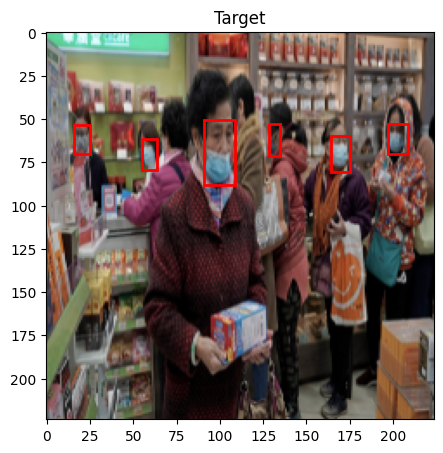

In [9]:
img, target, _ = dataset[35]

plot_img_bbox(img, [target]);

In [10]:
dataset = FaceMaskDataset(images_dir, annotations_dir, 480, 480, transforms= get_transform(train=True))
dataset_valid = FaceMaskDataset(images_dir, annotations_dir, 480, 480, transforms= get_transform(train=False))
dataset_test = FaceMaskDataset(test_imgs, test_anns, 480, 480, transforms= get_transform(train=False))

# разделим данные на train и test
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_valid = torch.utils.data.Subset(dataset_valid, indices[-tsize:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=collate_fn)

data_loader_valid = torch.utils.data.DataLoader(
    dataset_valid, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

# Обучение модели
We're going to use fasterrcnn_resnet50_fpn.

The model has 4 children: transform, backbone, rpn, roi_heads. Transform deals with input normalization. Backbone is a Resnet-50 architecture along with feature pyramid network. Region Proposal network (rpn) generates candidate proposals for Region of Interest network (roi_heads).

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 4

In [12]:
--

SyntaxError: invalid syntax (3659366440.py, line 1)

In [ ]:
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#num_classes = 4

model = get_model_instance_segmentation(num_classes)

num_epochs = 5

model.to(device)


params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)
len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations, _ in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()         
        epoch_loss += losses.item()

    model.eval()
    metric = torchmetrics.Accuracy(task='multiclass', num_classes=3)
    with torch.no_grade():
        for images, annotations in data_loader_test:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        
            trues = targets['labels']
            predict = model(images, annotations)[0]['labels']

            acc = metric(predict, trues)  
        acc = metric.compute()
        metric.reset()
    print('Epoch_loss = ',epoch_loss)


In [13]:
model = get_model_instance_segmentation(num_classes)
model.load_state_dict(torch.load('data/res.pt', map_location=torch.device('cpu')))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

### NMS
Performs non-maximum suppression (NMS) on the boxes according to their intersection-over-union (IoU).

NMS iteratively removes lower scoring boxes which have an IoU greater than iou_threshold with another (higher scoring) box.

If multiple boxes have the exact same score and satisfy the IoU criterion with respect to a reference box, the selected box is not guaranteed to be the same between CPU and GPU. This is similar to the behavior of argsort in PyTorch when repeated values are present.

In [14]:
img, target, _ = dataset_valid[1]

model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))
#prediction

predicted #boxes:  12
real #boxes:  9


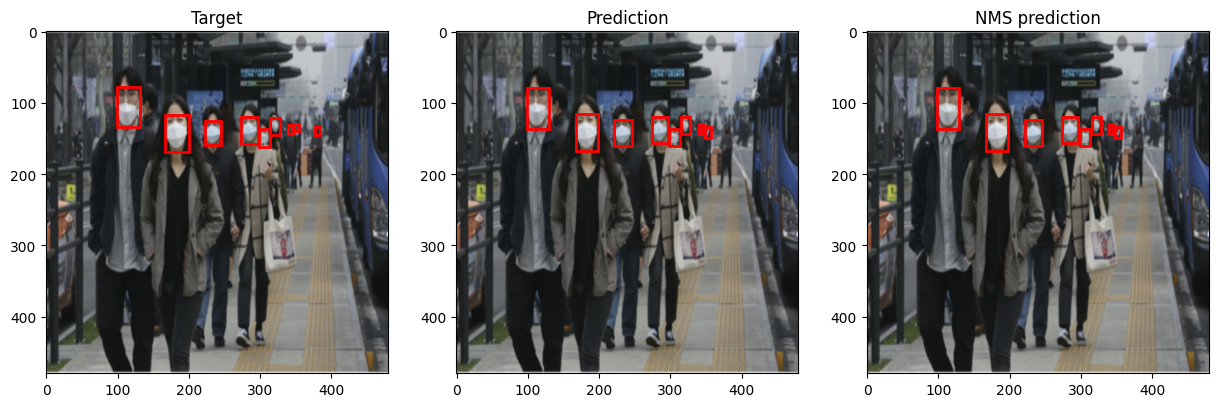

In [15]:
plot_img_bbox(torch_to_pil(img), [target, prediction, apply_nms(prediction, iou_thresh=0.2)])

In [ ]:
#print('EXPECTED OUTPUT')
#plot_img_bbox(torch_to_pil(img), target)

In [ ]:
#print('MODEL OUTPUT')
#plot_img_bbox(torch_to_pil(img), prediction)

In [ ]:
#nms_prediction = apply_nms(prediction, iou_thresh=0.95)
#print('NMS APPLIED MODEL OUTPUT')
#plot_img_bbox(torch_to_pil(img), nms_prediction)

# Отрисовка изображений

In [36]:
i = 0
for imgs, annotations, _ in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        if i == 3:
                break

In [37]:
model.eval()
with torch.no_grad():
    preds = model(imgs)


Prediction


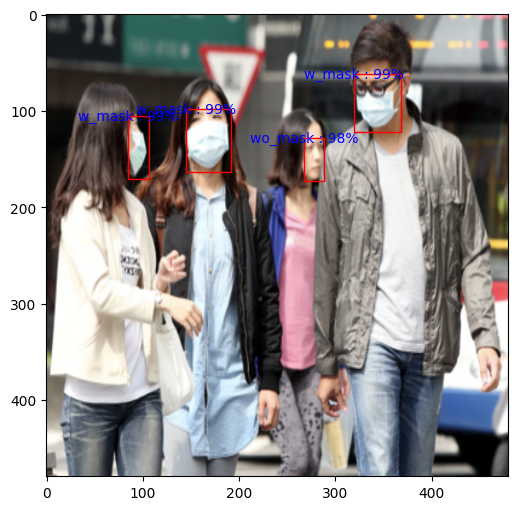

In [38]:
print("Prediction")
plot_image(imgs[3], preds[3])

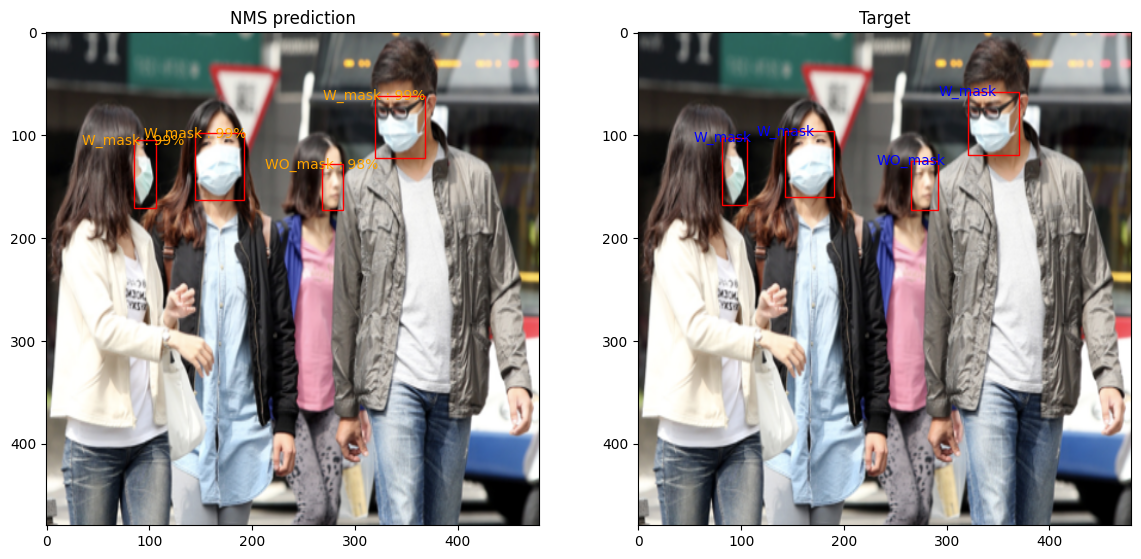

In [39]:
ids = 3
nms_prediction = apply_nms(preds[ids], iou_thresh=0.2)

plot_image_2(imgs[ids], [nms_prediction, annotations[ids]])

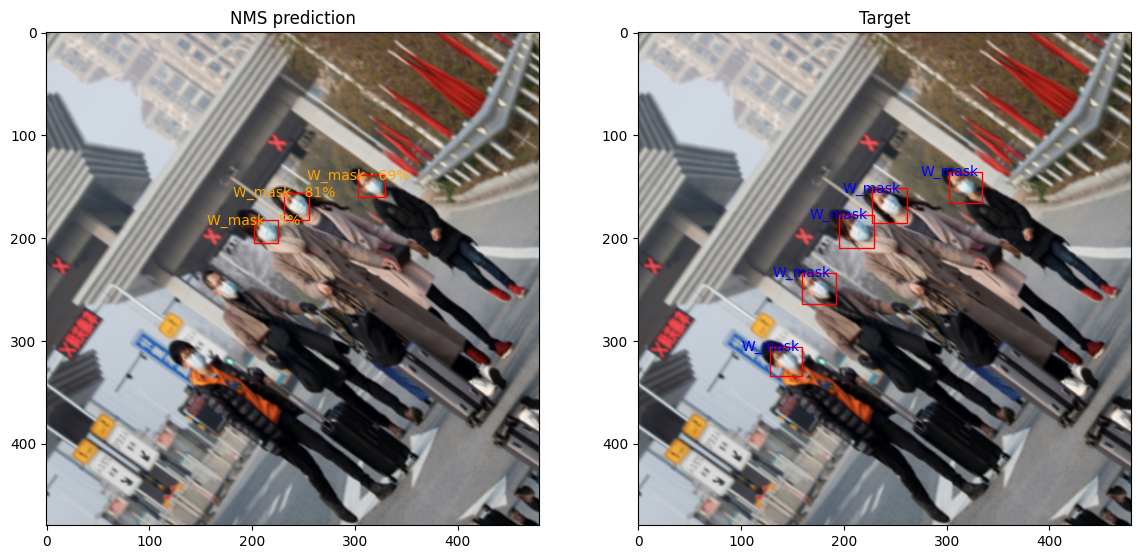

In [48]:
ids = 9
nms_prediction = apply_nms(preds[ids], iou_thresh=0.2)

plot_image_2(imgs[ids], [nms_prediction, annotations[ids]])


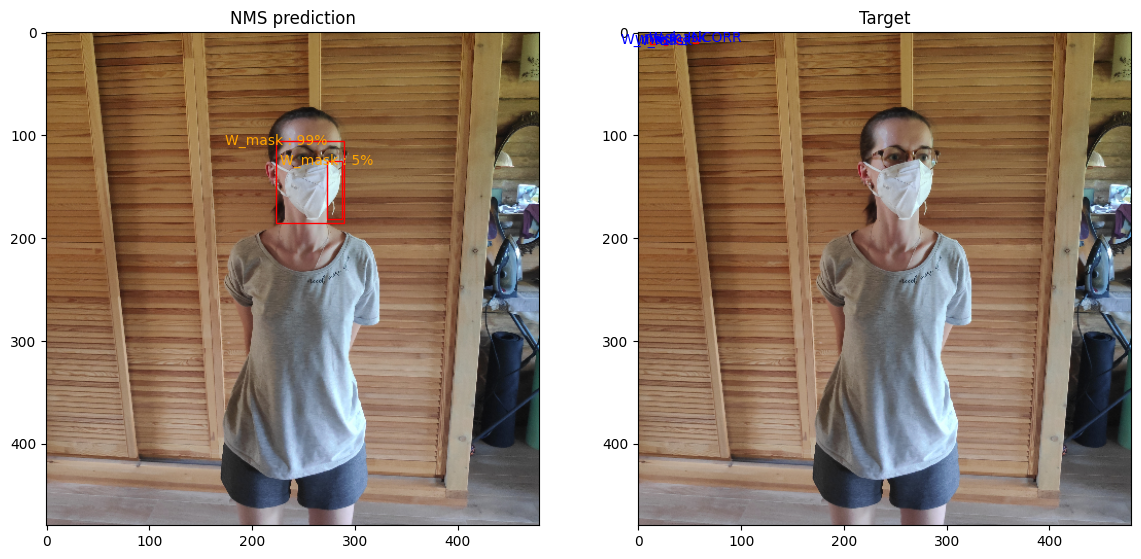

In [35]:
ids = 3
nms_prediction = apply_nms(preds[ids], iou_thresh=0.2)

plot_image_2(imgs[ids], [nms_prediction, annotations[ids]])

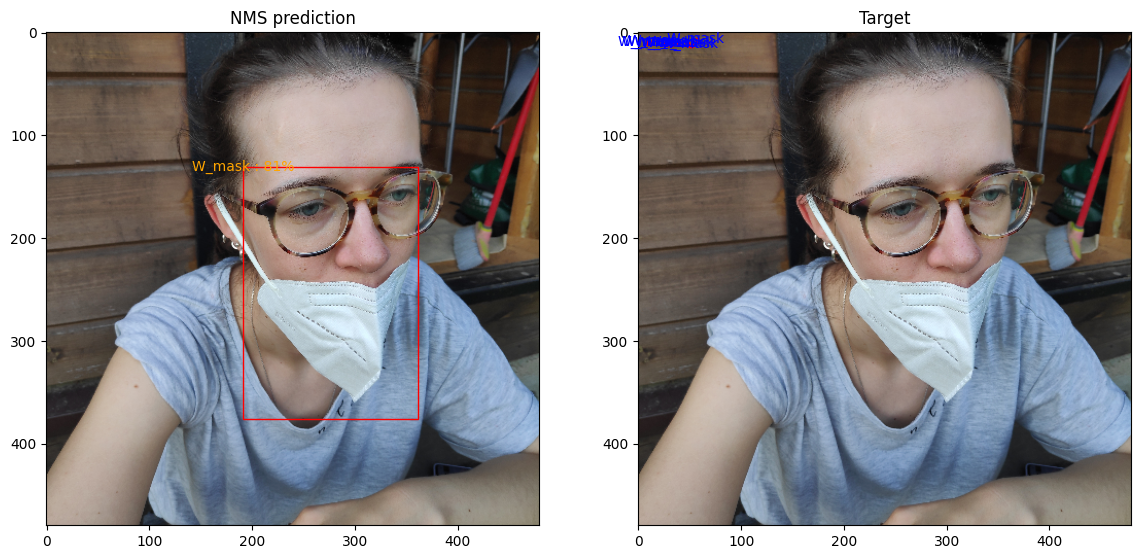

In [22]:
for imgs, annotations, _ in data_loader_test:
    i += 1
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

model.eval()
with torch.no_grad():
    preds = model(imgs)

ids = 1
nms_prediction = apply_nms(preds[ids], iou_thresh=0.2)

plot_image_2(imgs[ids], [nms_prediction, annotations[ids]])

### Model evaluation

In [ ]:
%%time

thresholds = [0.5, 0.75, 0.95] #np.arange(0.5, 1.05, 0.05).round(2)
df = pd.DataFrame()

model.eval()
with torch.no_grad():
    for ims, ans, _ in data_loader_valid:
        ims = list(image.to(device) for image in ims)
        ans = [{k: v.to(device) for k, v in a.items()} for a in ans]
        
        for t,p in zip(ans, model(ims)):
            for threshold in thresholds:#np.arange(0.5, 1.05, 0.05):
                df = get_scores2(df, t, p, threshold)
                #df = pd.concat([df,pd.DataFrame(new_entry)], axis=0, ignore_index=True)
        
    print(df.shape)            


print(f"Labels unique: {df['label'].unique()}")
df.head(3)

(4104, 8)
CPU times: user 14min 27s, sys: 4min 25s, total: 18min 53s
Wall time: 5min 14s


TP  FP  label  threshold  GT     score   id       iou
13   0   1      1       0.75   0  0.120711  204  0.000000
14   1   0      2       0.75   8  0.997145  204  0.834107
15   1   0      2       0.75   8  0.995263  204  0.885770

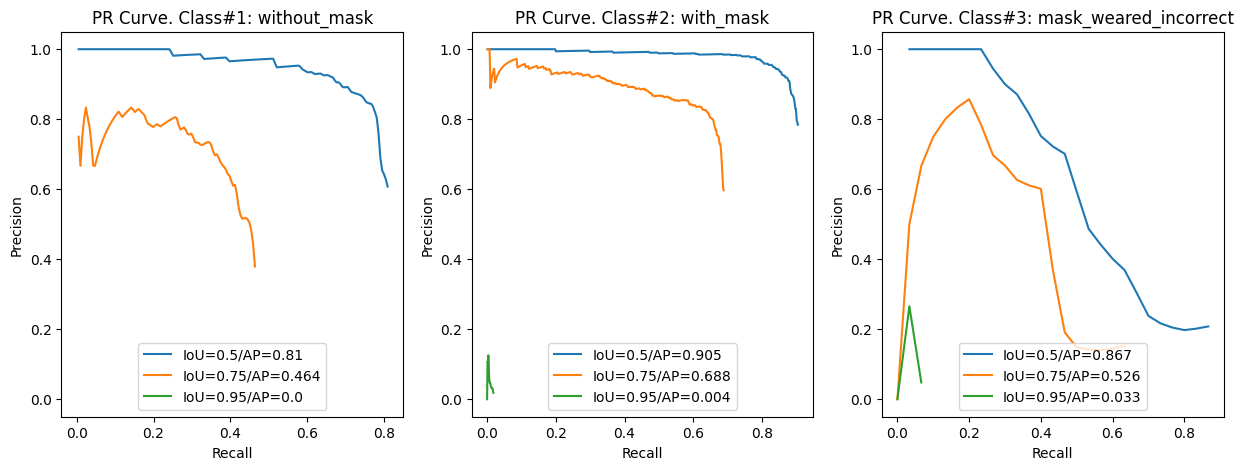

mAP50 = 0.8606


In [ ]:
classes_unique = sorted(df['label'].unique())
classes_decoder = dataset.__dict__['dataset'].__dict__['classes']

f,a = plt.subplots(1,len(classes_unique),figsize=(len(classes_unique)*5,5))
mAP = []
for n,label in enumerate(classes_unique):
    aps = []
    for threshold in [0.5, 0.75, 0.95]:
        dfs = df[(df['threshold']==threshold) & (df['label']==label)].sort_values(['score'], ascending=False)
        dfs['cum TP'] = dfs['TP'].cumsum()
        dfs['cum FP'] = dfs['FP'].cumsum()
        dfs['precision'] = dfs['cum TP'] / (dfs['cum TP'] + dfs['cum FP'])
        GT = dfs.groupby('id')['GT'].mean().sum()
        dfs['recall'] = dfs['cum TP'] / GT
    
        AP = get_AP(dfs['precision'].values, dfs['recall'].values)
        
        sns.lineplot(data=dfs, x='recall', y='precision', label = f"IoU={threshold}/AP={round(AP,3)}", ax=a[n], errorbar=None).set(
            xlabel='Recall', 
            ylabel='Precision', 
            title=f'PR Curve. Class#{label}: {classes_decoder[label]}')
        a[n].legend(loc='lower center')

        aps.append(AP)

    class_AP = round(np.mean(aps),3)
    mAP.append(aps[0])
    #a[n].text(0.1,0.8, f'AP_cl{label}={class_AP}', fontsize=14, color='red')
plt.show()

print(f"mAP50 = {round(np.mean(mAP),4)}")

## YOLOV5

In [58]:
im_path = 'data/'

for i in ["train", "valid"]:
    if not os.path.exists(im_path + i):
        os.mkdir(im_path + i)
    else:
        shutil.rmtree((im_path + i))
        os.mkdir(im_path + i)
    os.mkdir(im_path + i + '/images')
    os.mkdir(im_path + i + '/labels')

In [60]:
def convert_to_yolov(data_loader, tofolder='train'):

    img_objects = dict()
    # for each object
    for ims, ans, names in data_loader:
        for im,an,name in zip(ims,ans, names):
            img_objects[name] = []
            
            #print(len(an['labels']), an['labels'])
            #print(an['boxes'])
            for num in range(len(an['boxes'])):
                box = an['boxes'][num] 
                class_id = an['labels'][num].item()

                X = ((box[0] + box[2]) / 2).item()
                Y = ((box[1] + box[3]) / 2).item()
                Width = (box[2] - box[0]).item()
                Height = (box[3] - box[1]).item()
                #print(X,Y,Width, Height)
                # normalization
                img_shape = im.shape
                #print(img_shape)
                image_c, image_w, image_h = img_shape[0], img_shape[1], img_shape[2]
                #print(image_c, image_w, image_h)
                X /= image_w
                Y /= image_h
                Width /= image_w
                Height /= image_h

                img_objects[name].append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, X, Y, Width, Height))
            save_image(im, f"data/{tofolder}/images/{name}")
    #return img_objects

    #print(img_objects)
    for key in img_objects.keys():
        # naming a file
        save_file_name = os.path.join(f"data/{tofolder}/labels/", key.replace("png","txt"))
        #print(save_file_name)
        # save the file on hdd
        print("\n".join(img_objects[key]), file= open(save_file_name, "w"))
        #
        #shutil.copy(f"data/images/{key}", f"data/{tofolder}/images/{key}")
        

#%cd /content
# generate annotation files
#convert_to_yolov5(xml_df, unique_img_names)

convert_to_yolov(data_loader, 'train')
convert_to_yolov(data_loader_valid, 'valid')


libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


In [61]:
print(f"TRAIN images: {len(os.listdir('data/train/images'))}")
print(f"TRAIN annotations: {len(os.listdir('data/train/labels'))}")

print(f"VALID images: {len(os.listdir('data/valid/images'))}")
print(f"VALID annotations: {len(os.listdir('data/valid/labels'))}")

TRAIN images: 683
TRAIN annotations: 683
VALID images: 170
VALID annotations: 170


In [ ]:
copy_tree("data/train/", '/home/ss/Documents/ds/git/SF_2/yolov5/datasets/mask/train/')
copy_tree("data/valid/", '/home/ss/Documents/ds/git/SF_2/yolov5/datasets/mask/valid')

random annotation: ['data/train/labels/maksssksksss448.txt']
480 480 2.0 94.56 86.88 141.6 186.71999999999997
480 480 2.0 163.44 75.35999999999999 204.24 153.12
480 480 2.0 201.36 133.44 246.96 224.64
480 480 2.0 300.0 111.11999999999999 361.44 220.07999999999998


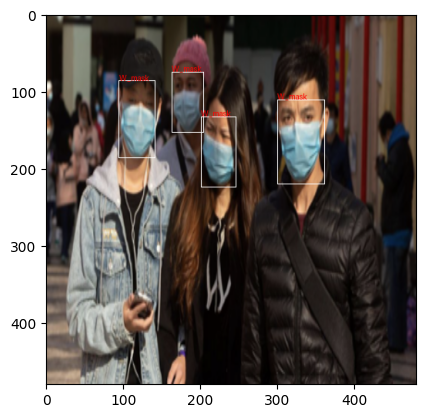

In [72]:
annotation_random = !ls data/train/labels/*txt | shuf -n 1
#annotation_random = ['data/train/labels/maksssksksss263.txt']
#annotation_random = ['data/train/labels/maksssksksss179.txt']
print(f"random annotation: {annotation_random}")

annotation_file = annotation_random[0]
with open(annotation_file, "r") as file:
    ann_list = file.read().split("\n")[:-1]
    #print(annotation_list)
    ann_list = [x.split(" ") for x in ann_list]
    ann_list = [[float(y) for y in x ] for x in ann_list]
    #print(annotation_list)

#Get the corresponding image file
im_file = annotation_file.replace("txt", "png").replace("labels", "images")
#print(image_file)
assert os.path.exists(im_file)

#Load the image
im = pilim.open(im_file)

#Plot the Bounding Box
plot_bounding_box(im, ann_list)

In [73]:
os.chdir('/home/ss/Documents/ds/git/SF_2/yolov5')
!pwd

/home/ss/Documents/ds/git/SF_2/yolov5


In [74]:
!python3 detect.py --weights yolov5s.pt --img 480 --conf 0.25 --source data/images/masks

detect: weights=['yolov5s.pt'], source=data/images/masks, data=data/coco128.yaml, imgsz=[480, 480], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-350-g6096750f Python-3.10.12 torch-2.4.0+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/11 /home/ss/Documents/ds/git/SF_2/yolov5/data/images/masks/1.jpg: 480x480 1 person, 103.7ms
image 2/11 /home/ss/Documents/ds/git/SF_2/yolov5/data/images/masks/11.jpg: 480x480 1 person, 96.4ms
image 3/11 /home/ss/Documents/ds/git/SF_2/yolov5/data/images/masks/111.png: 320x480 11 persons, 75.1ms
image 4/11 /home/ss/Documents/ds/git/SF_2/yolov5/data/images/masks/2.j

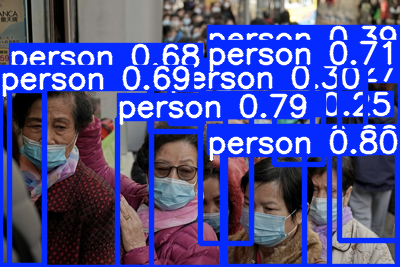

In [75]:
Image(filename='./runs/detect/exp22/111.png', width=500)
#pilim.open('./runs/detect/exp13/111.jpg')

In [76]:
!python3 train.py --img 480 --batch 4 --epochs 20 --data data/mask.yaml --cfg models/yolov5s.yaml --weights yolov5s.pt --name yolov5s_results  --cache

train: weights=yolov5s.pt, cfg=models/yolov5s.yaml, data=data/mask.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=4, imgsz=480, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: ⚠️ YOLOv5 is out of date by 6 commits. Use 'git pull' or 'git clone https://github.com/ultralytics/yolov5' to update.
YOLOv5 🚀 v7.0-350-g6096750f Python-3.10.12 torch-2.4.0+cu121 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup

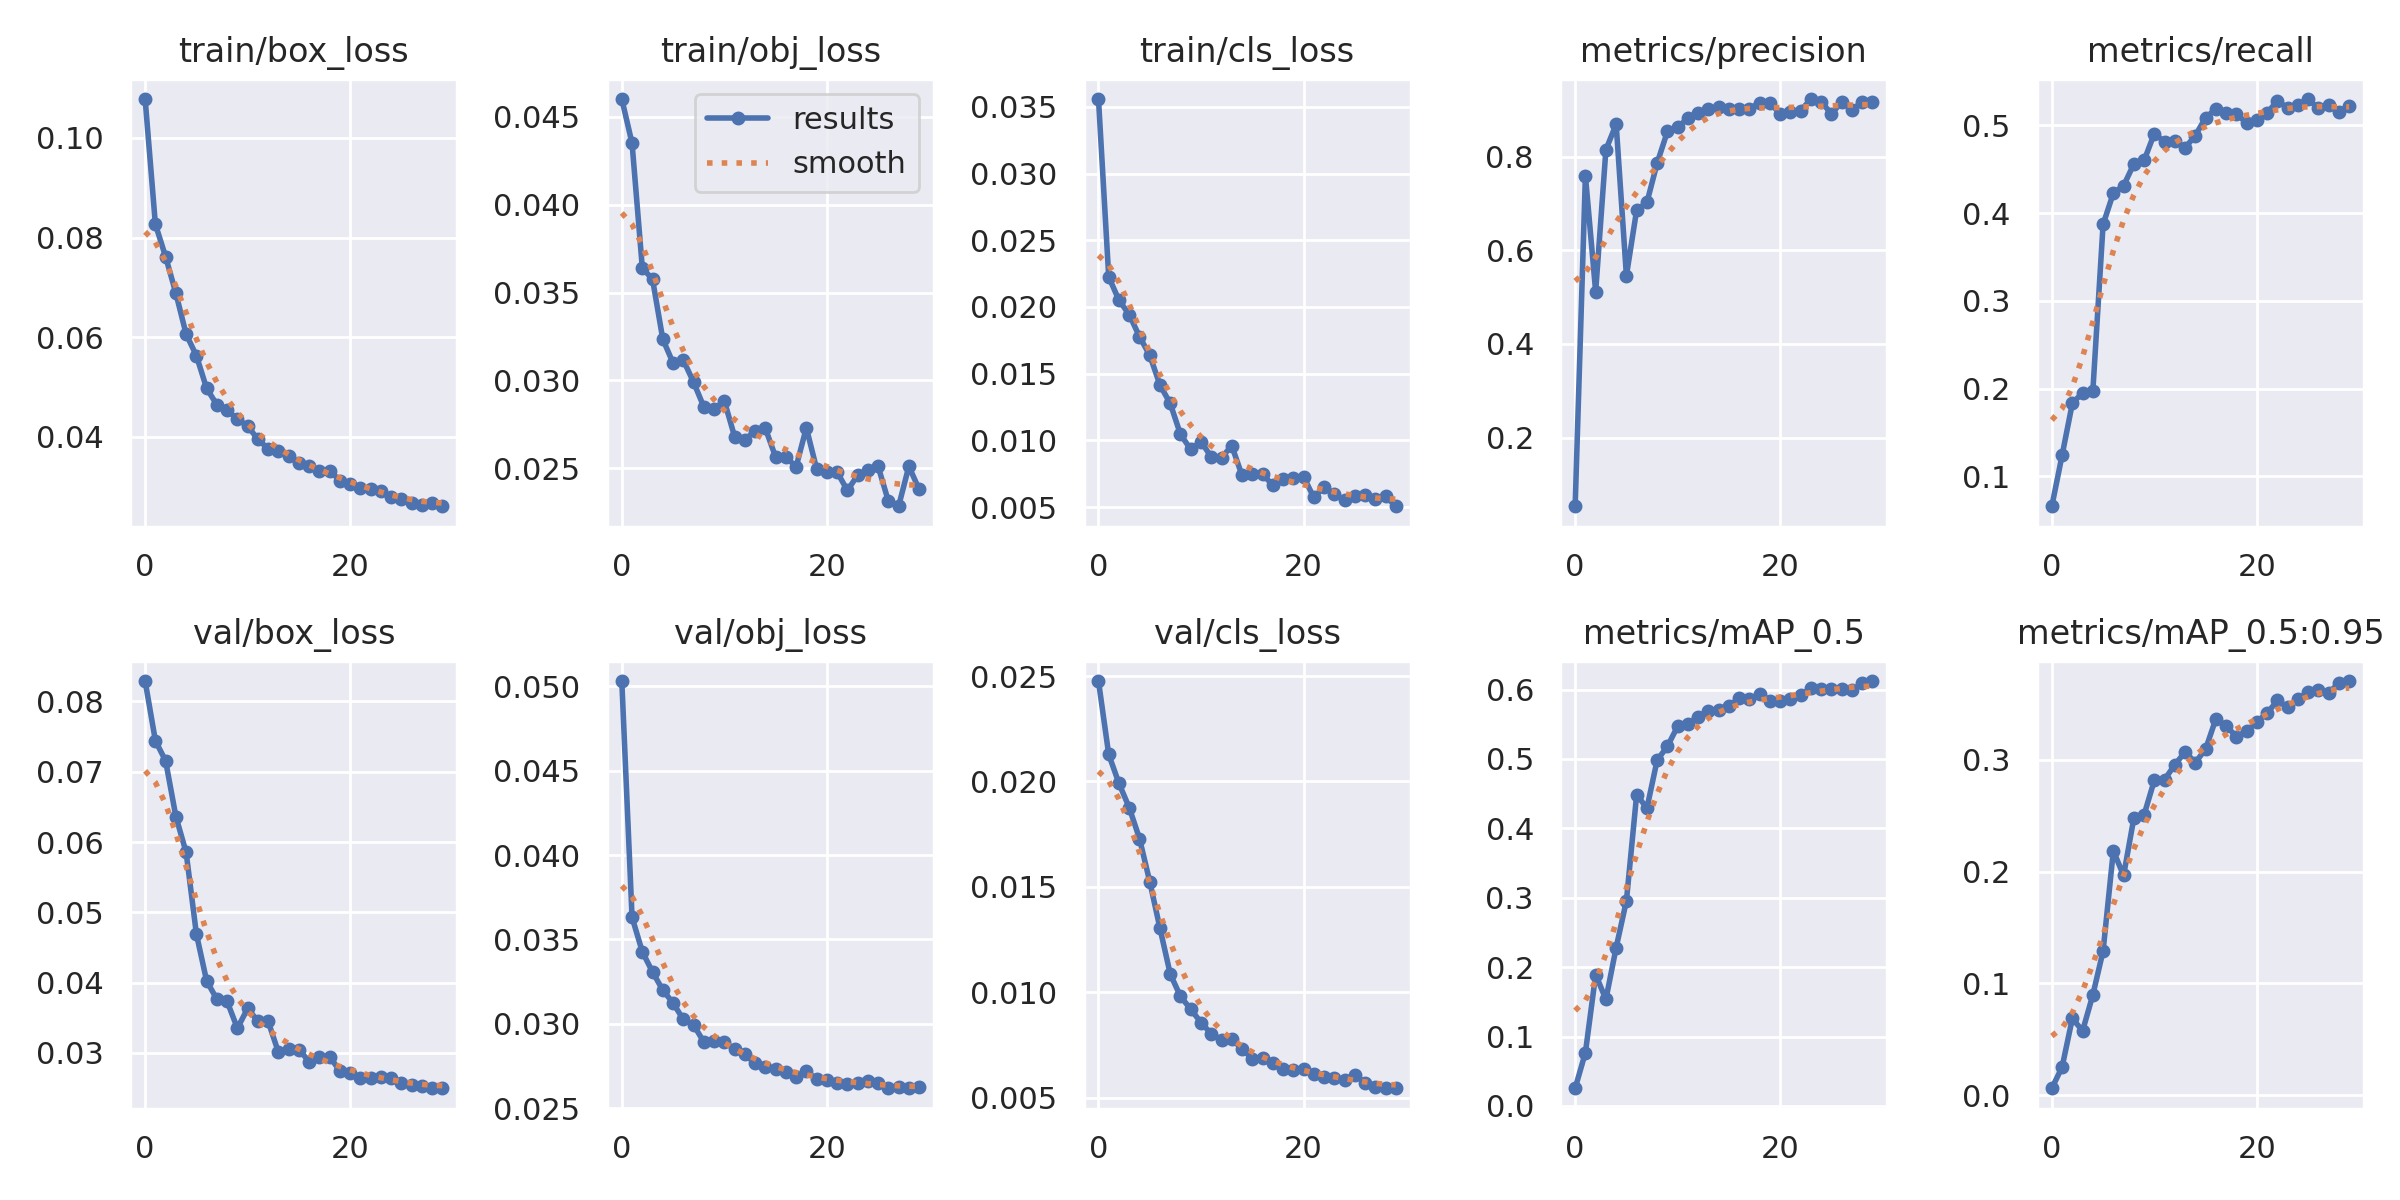

In [ ]:
Image(filename='runs/train/yolov5s_results4/results.png') # 20 epochs
Image(filename='runs/train/yolov5s_results5/results.png') # 30 epochs
Image(filename='runs/train/yolov5s_results6/results.png') # 20 epochs + augm

In [ ]:
!python3 detect.py --weights runs/train/yolov5s_results6/weights/best.pt --img 480 --conf 0.4 --source data/images/masks

detect: weights=['runs/train/yolov5s_results5/weights/best.pt'], source=data/images/masks, data=data/coco128.yaml, imgsz=[480, 480], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-350-g6096750f Python-3.10.12 torch-2.4.0+cu121 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
image 1/11 /home/ss/Documents/ds/git/SF_2/yolov5/data/images/masks/1.jpg: 480x480 1 WO_mask, 66.1ms
image 2/11 /home/ss/Documents/ds/git/SF_2/yolov5/data/images/masks/11.jpg: 480x480 1 W_mask, 57.8ms
image 3/11 /home/ss/Documents/ds/git/SF_2/yolov5/data/images/masks/111.png: 320x480 1 WO_mask, 21 W_masks, 51.8ms
image 4/11 /home/ss/Documen

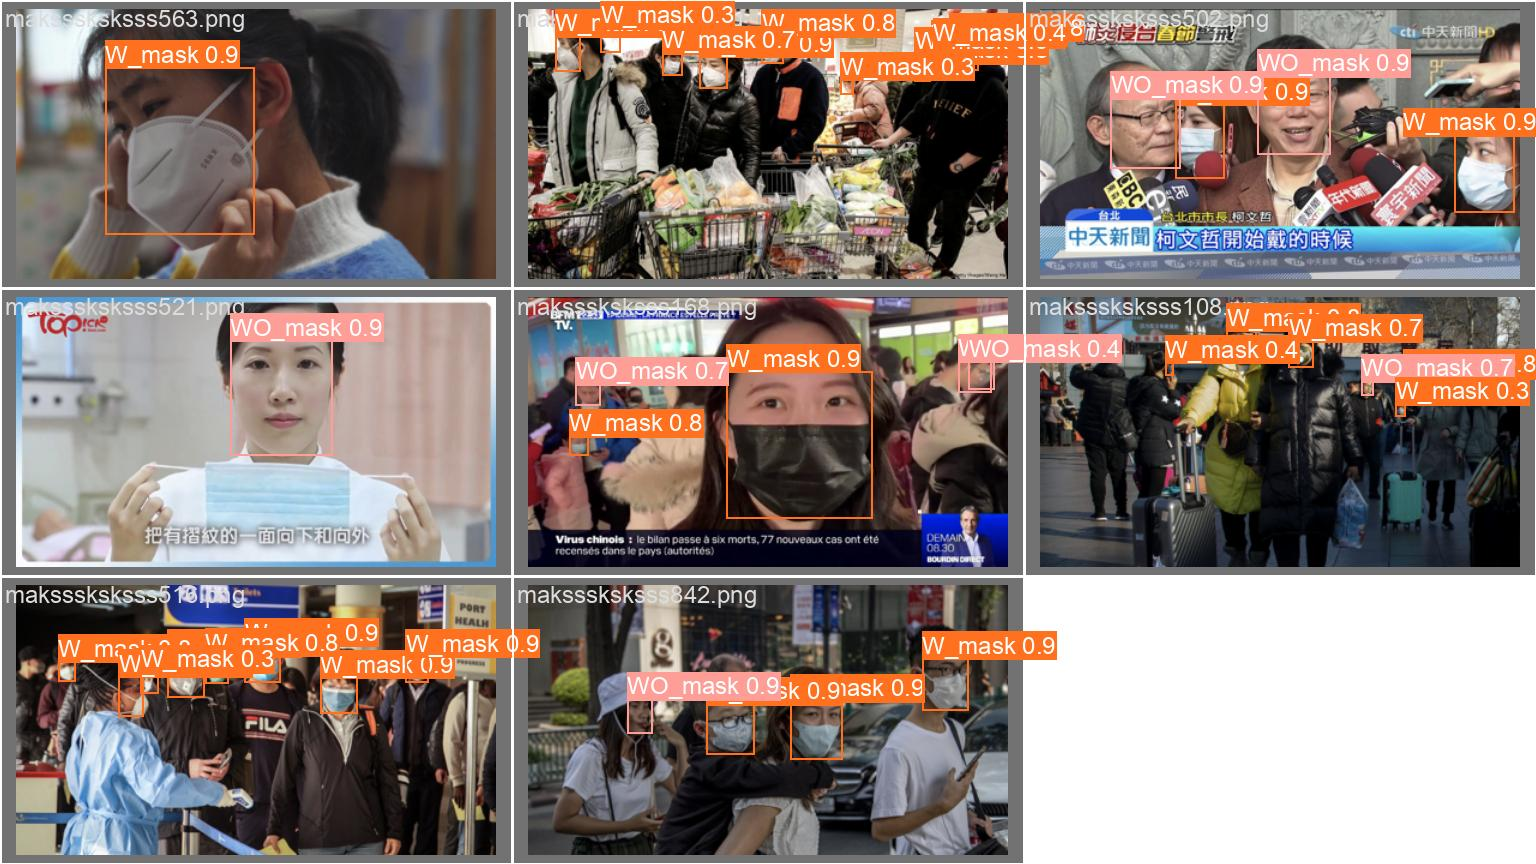

In [ ]:
Image(filename='./runs/train/yolov5s_results5/val_batch2_pred.jpg', width=1000)

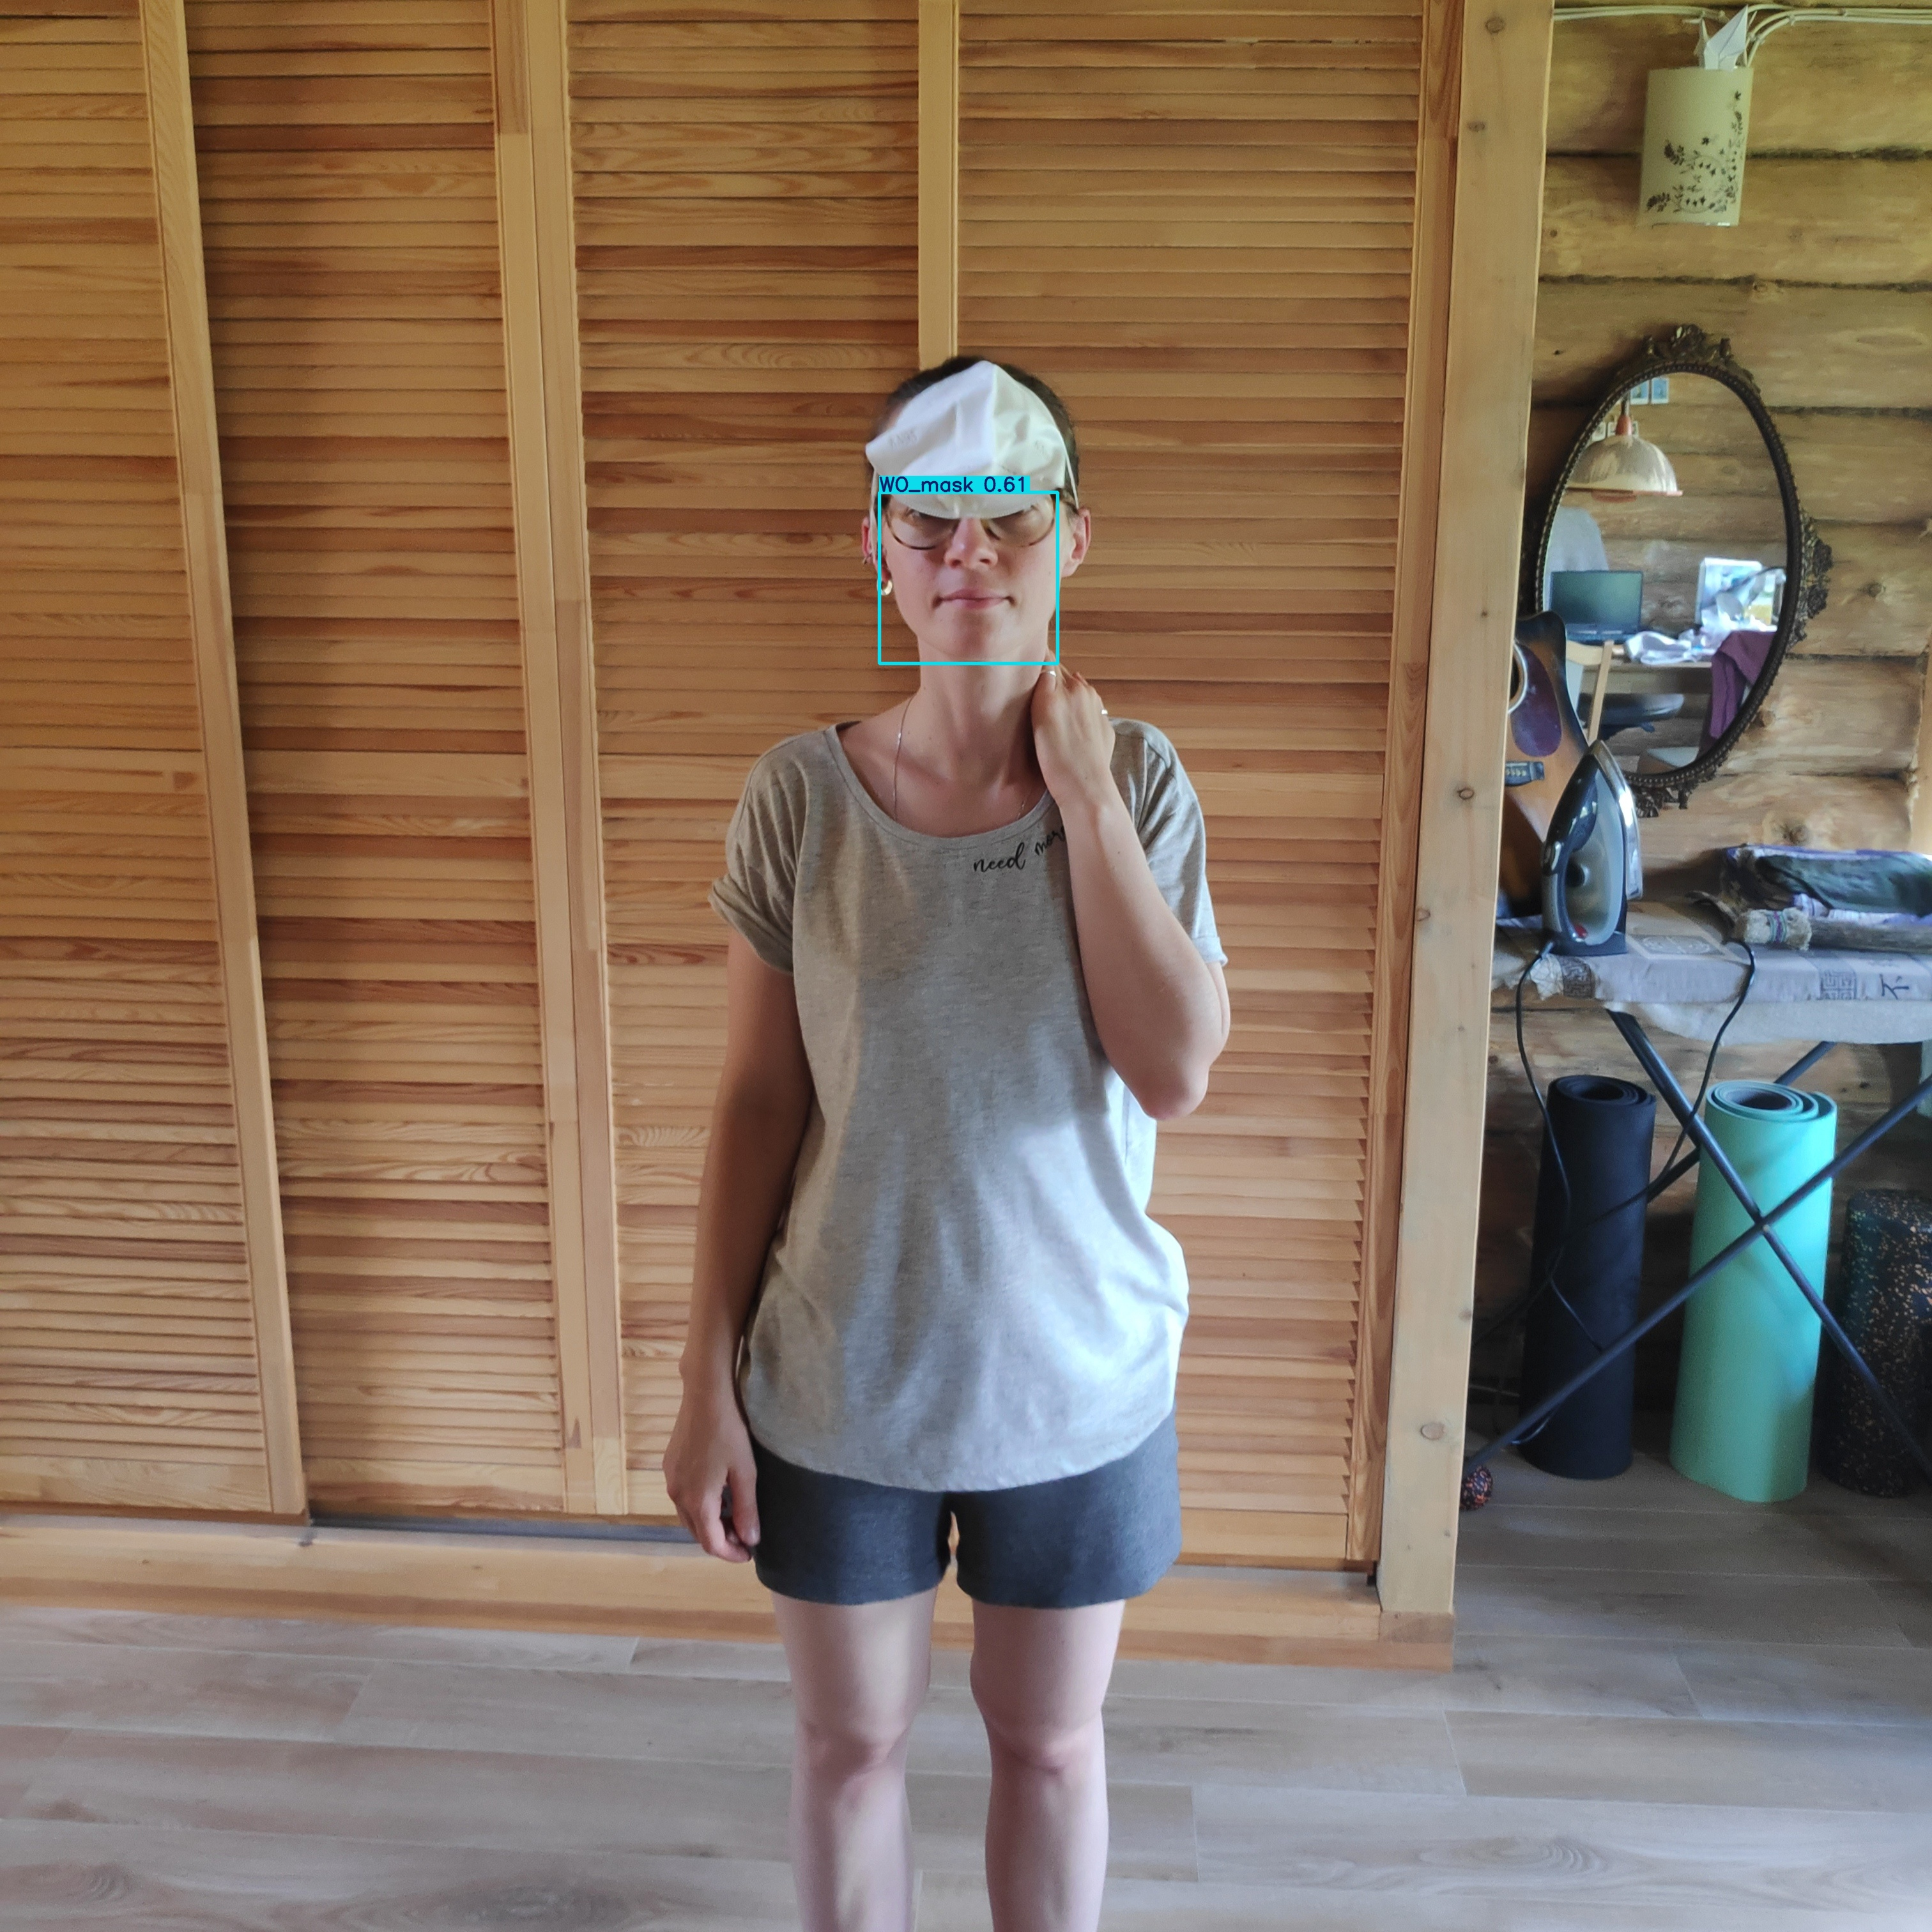

In [ ]:
Image(filename='./runs/detect/exp15/1.jpg', width=700)

In [ ]:
#os.chdir('/home/ss/Documents/ds/git/SF_2/yolov5')
path_to_yolo = '/home/ss/Documents/ds/git/SF_2/yolov5'
path_to_bestpt = '/runs/train/yolov5s_results5/weights/best.pt'
args = list([path_to_yolo, 'custom', path_to_yolo+path_to_bestpt])

# Model
model = get_yolo(path_to_yolo, path_to_bestpt)
#yolov5 = torch.hub.load(path_to_yolov5, 'custom', path_to_yolov5+path_to_bestpt, source='local')  # custom trained model
model = model.to(device)
# Images
pict = path_to_yolo + '/data/images/masks/1.jpg'  # or file, Path, URL, PIL, OpenCV, numpy, list

# Inference
results = model(pict)

# Results
results.print()  # or .show(), .save(), .crop(), .pandas(), etc.

results.xyxy[0]  # im predictions (tensor)
results.pandas().xyxy[0]  # im predictions (pandas)

YOLOv5 🚀 v7.0-350-g6096750f Python-3.10.12 torch-2.4.0+cu121 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
image 1/1: 3024x3024 1 WO_mask
Speed: 85.1ms pre-process, 120.8ms inference, 0.8ms NMS per image at shape (1, 3, 640, 640)


xmin        ymin         xmax         ymax  confidence  class   
0  1382.304443  754.112915  1666.549072  1020.175049    0.789946      1  \

      name  
0  WO_mask

In [ ]:
#os.chdir('/home/ss/Documents/ds/git/MedMask_detection')
!pwd

/home/ss/Documents/ds/git/SF_2/yolov5


In [ ]:
%%time

thresholds = [0.5, 0.75, 0.95] #np.arange(0.5, 1.05, 0.05).round(2)
df = pd.DataFrame()

model.eval()
with torch.no_grad():
    for ims, ans, _ in data_loader_valid:
        #ims = list(image.to(device) for image in ims)
        ims = list(image.to(device) for image in ims)
        ans = [{k: v.to(device) for k, v in an.items()} for an in ans]
        
        for t,i in zip(ans, ims):
            p = model(np.moveaxis(i.cpu().numpy(),0,-1)*255)
            #p = p.pandas().xyxy[0]
                    
            for threshold in thresholds:
                df = get_scores3(df, t, p, threshold, yolov=True)
               #df = pd.concat([df,pd.DataFrame(new_entry)], axis=0, ignore_index=True)
        
    print(df.shape)            



print(f"Labels unique: {df['label'].unique()}")
df.head(3)

(2973, 8)
Labels unique: [1 2]
CPU times: user 1min 25s, sys: 305 ms, total: 1min 25s
Wall time: 23.2 s


TP  FP  label  threshold  GT     score   id       iou
0   0   1      1        0.5   0  0.533051  204  0.000000
1   1   0      2        0.5   8  0.923262  204  0.845188
2   1   0      2        0.5   8  0.905235  204  0.826854

0 1
1 2


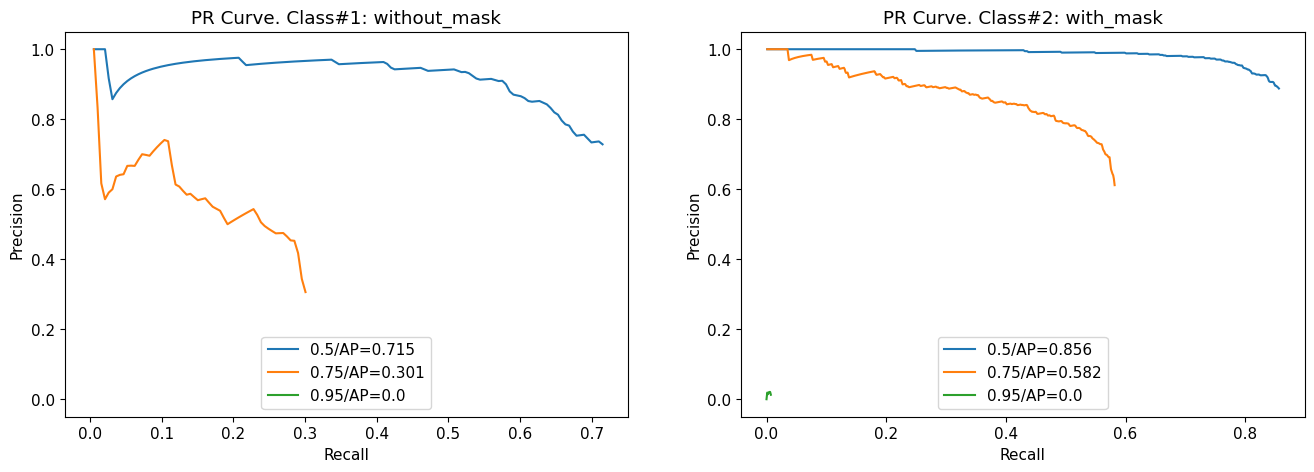

mAP50 = 0.7856


In [ ]:
classes_unique = sorted(df['label'].unique())
classes_decoder = dataset.__dict__['dataset'].__dict__['classes']

fig,axe = plt.subplots(1,len(classes_unique),figsize=(16,5))
mAP = []
for n,label in enumerate(classes_unique):
    print(n,label)
    aps = []
    for threshold in [0.5, 0.75, 0.95]:
        dfs = df[(df['threshold']==threshold) & (df['label']==label)].sort_values(['score'], ascending=False)
        dfs['cum TP'] = dfs['TP'].cumsum()
        dfs['cum FP'] = dfs['FP'].cumsum()
        dfs['precision'] = dfs['cum TP'] / (dfs['cum TP'] + dfs['cum FP'])
        GT = dfs.groupby('id')['GT'].mean().sum()
        dfs['recall'] = dfs['cum TP'] / GT
        #display(dfs.head())
        AP = get_AP(dfs['precision'].values, dfs['recall'].values)
        
        sns.lineplot(data=dfs, x='recall', y='precision', label = f"{threshold}/AP={round(AP,3)}", ax=axe[n], errorbar=None).set(
            xlabel='Recall', 
            ylabel='Precision', 
            title=f'PR Curve. Class#{label}: {classes_decoder[label]}')
        axe[n].legend(loc='lower center')

        aps.append(AP)

    class_AP = round(np.mean(aps),3)
    mAP.append(aps[0])
    #a[n].text(0.1,0.8, f'AP_cl{label}={class_AP}', fontsize=14, color='red')
plt.show()

print(f"mAP50 = {round(np.mean(mAP),4)}")